Hqq uses a slightly different packing and quanting method than `python_hqq_qdora.ipynb`. In this nb, I use that.

The steps are:

0. Take the reference implementation from `python_hqq_qdora.ipynb`
1. Implement packing as hqq does it
2. Implement (de)quanting as hqq does it, without the optimization
3. Quant zero and scales
4. Use hqq's optimization in quanting
5. Put it all toghether!

Also note: I'm not using inheritance to produce cleaner code in this nb. The goal is to have a single class with all the functionality in one place. This will make it easier later to write kernels.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from copy import deepcopy
from torch import tensor, cat, int32, float16 as fp16, float32 as fp32
from math import ceil

from fastcore.foundation import L, Self
from fastcore.basics import store_attr

from tabulate import tabulate

from hqq.core.quantize import Quantizer

torch.set_printoptions(linewidth=200, precision=2, sci_mode=False)

Matplotlib created a temporary cache directory at /tmp/matplotlib-r94u9uy7 because the default path (/teamspace/studios/this_studio/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
def randint(n, lo=2, hi=100):
    r = torch.randint(low=2, high=100, size=(n,)).tolist()
    return r[0] if len(r)==1 else r

def rand(*shape): # normalized random numbers, otherwise quanting error depends on size of data
    if len(shape)==1: shape=shape[0] # allow rand(a,b) or rand(shape)
    assert len(shape)==2
    o,i=shape
    return nn.Linear(i,o,bias=False).weight.data

In [3]:
def max_abs_diff(a,b): return (a-b).abs().max()
def assert_close(a,b): assert torch.isclose(a,b,atol=1e-2).all(), f'assert_close failed, max error = {max_abs_diff(a,b)}'
def assert_somehow_close(a,b,max_err=0.12): assert torch.isclose(a,b,atol=max_err).all(), f'assert_somehow_close failed, max error = {max_abs_diff(a,b)}' # allow some error due to quanting

___

## 0. Current reference implementation from `python_hqq_qdora`

In [4]:
base_linear = nn.Linear(4,5, bias=False, dtype=fp16) # ignore bias for now
base_linear.weight.data

tensor([[ 0.15,  0.42,  0.14,  0.48],
        [-0.08,  0.32,  0.31, -0.12],
        [-0.27, -0.45, -0.06, -0.34],
        [-0.33,  0.01,  0.33, -0.25],
        [ 0.29,  0.09, -0.33, -0.09]], dtype=torch.float16)

In [5]:
tst_x = torch.randn(4, dtype=fp16); tst_x

tensor([ 0.90, -0.06,  0.36, -0.53], dtype=torch.float16)

In [6]:
tst_result = base_linear(tst_x); tst_result

tensor([-0.10,  0.09, -0.06, -0.05,  0.19], dtype=torch.float16, grad_fn=<SqueezeBackward4>)

This is `QuantedDoraModule` from `python_hqq_qdora.ipynb`:

In [7]:
class QuantedDoraModule(nn.Module):
    def __init__(self, linear, bits, group_size, rank, alpha):
        super().__init__()
        # for quanting
        assert base_linear.weight.numel() % group_size ==0, f'group_size {group_size} can\'t cleanly split weight of base layer ({base_linear.weight.numel()} items)'
        self.bits,self.group_size, = bits,group_size
        self.quant(linear)
        # for dora
        self.a = nn.Linear(linear.in_features, rank, bias=False, dtype=fp16)
        self.b = nn.Linear(rank, linear.out_features, bias=False, dtype=fp16)
        self.alpha = alpha
        self.m = nn.Parameter(linear.weight.norm(p=2, dim=1))
        # init a & b to 0 -- a should be inited differently, but for sake of simplicity, set it to 0 as well
        self.a.weight.data.zero_()
        self.b.weight.data.zero_()

    def quant(self, linear):
        data = linear.weight.data
        self.shape = data.shape

        # repeat last element, to have a multiple of group_size elements
        # note: element to pad with mustn't change any attribute that's use for quanting (eg min & max in a group)
        n_pad = data.numel()%self.group_size
        data = F.pad(data, (0,n_pad), 'constant', data.flatten()[-1])
        assert data.numel()%self.group_size==0

        data = data.reshape(-1,self.group_size)
        
        min_, max_ = data.min(axis=-1, keepdim=True).values, data.max(axis=-1, keepdim=True).values
        
        self.zero = min_
        self.scale = (max_-min_) / (2**self.bits-1) 
        
        # note: can't use shorthand ops like -= as they modify tensor in-place
        data = data - self.zero # start at 0
        data = data / self.scale # scale to [0, 2**bits-1]
        data = data.round().to(int)

        # packed quantized data
        self.pqdata = self.pack(data.flatten())

    # pack 10 3bit values into a 32bit val
    @staticmethod
    def pack(vals):
        for v in vals: assert 0<=v<=7 and v//1==v, f'Value {v} can\'t be represented by 3 bits or is not an integer'
        
        n_packs = ceil(len(vals)/10)
    
        # pad with 0, to have a multiple of pack_size elements
        n_pad = n_packs*10 - len(vals)
        vals = F.pad(vals, (0,n_pad), 'constant', 0)
        assert len(vals)==n_packs*10
    
        packed = torch.zeros(n_packs, dtype=int32)
        for i in range(n_packs):
            # pack the 10 vals from 10*i to 10*(i+1) into packed[i]
            for x in vals[10*i:10*(i+1)]: packed[i] = (packed[i] << 3) | x # shift right 3 bits, then set last 3 bits to x
        return packed

    def dequant(self):
        data = self.unpack(self.pqdata)[:self.shape.numel()] # unpack & remove padding that was added during packing
        data = data.reshape(-1,self.group_size)
        data = data*self.scale + self.zero
        return data.reshape(self.shape)
    
    # unpack a 32bit value into 10 3bit vals
    @staticmethod
    def unpack(packed):
        def bin_to_dec(b3,b2,b1): return 4*b3 + 2*b2 + b1
        for v in packed: isinstance(v, int), f'Value {v} is not an integer'
        unpacked = []
        for pack in packed:
            for i in reversed(range(10)):
                unpacked.append((pack >> (3*i)) & 0b111) # righ-shift 3*i times, so last 3 bits are those we want; then only select those via 0b111            
        return tensor(unpacked)
    
    def forward(self, x):
        x = self.dequant()@x + self.b(self.a(x))
        col_norms =  (self.dequant() + self.b.weight @ self.a.weight).norm(p=2, dim=1).detach()
        x /= col_norms
        x *= self.m * self.alpha
        return x

In [8]:
qdora = QuantedDoraModule(base_linear, bits=3, group_size=5, rank=2, alpha=1); qdora

QuantedDoraModule(
  (a): Linear(in_features=4, out_features=2, bias=False)
  (b): Linear(in_features=2, out_features=5, bias=False)
)

In [9]:
print(f'quanted result (with packing): {qdora(tst_x)}')
print(f'exact   result               : {tst_result}')
assert_somehow_close(qdora(tst_x), tst_result)

quanted result (with packing): tensor([-0.08,  0.09, -0.02, -0.06,  0.17], dtype=torch.float16, grad_fn=<MulBackward0>)
exact   result               : tensor([-0.10,  0.09, -0.06, -0.05,  0.19], dtype=torch.float16, grad_fn=<SqueezeBackward4>)


## 1. Packing as in hqq

hqq packs column-wise and interwovenly. For example, for `group_siz=3` (so 3 columns) and 2 packs per columns (ie 11-20 elements per column), the data matrix
$$
\begin{bmatrix}
a & b & c \\
d & e & f \\
g & h & i \\
j & k & l \\
\vdots & \vdots & \vdots
\end{bmatrix}
$$
is packed into:
$$
\begin{bmatrix}
Pack(a,g,...) & Pack(b,h,...) & Pack(c,i,...) \\
Pack(d,j,...) & Pack(e,k,...) & Pack(f,l,...) \\
\end{bmatrix}
$$

In [10]:
def pack(vals):
    assert len(vals.shape)==2, 'Pass a 2d tensor'
    for v in vals.flatten(): assert 0<=v.item()<=7 and v.item()//1==v.item(), f'Value {v} can\'t be represented by 3 bits or is not an integer'    
    rows, cols = vals.shape
    n_packs = ceil(rows/10) # packs per col
    padded_vals = torch.zeros(n_packs*10, cols, dtype=int32)
    padded_vals[:rows, :cols] = vals
    packed = torch.zeros(n_packs, cols, dtype=int32)

    for j in range(cols):
        for i in range(n_packs):
            for k in range(10):
                packed[i,j] = (packed[i,j] << 3) | padded_vals[n_packs*k+i,j] # shift right 3 bits, then set last 3 bits to x
    return packed

In [11]:
to_pack = torch.ones(11,1, dtype=int32)

In [12]:
pack(to_pack)

tensor([[153391104],
        [153387008]], dtype=torch.int32)

In [13]:
from hqq.core.bitpack import BitPack
BitPack.pack_3bit_32(to_pack)

tensor([[153391104],
        [153387008]], dtype=torch.int32)

Matches!

We can vectorize the loops. Let's do that next. Hqq also does that.

There are 3 loops: `j` over cols, `i` over packs, and `k` over 3bit-values. We'll vectorized the `j` and `i` loops. This means, in each iteration over `k`, we'll bit-shift the current packed tensor (shape `(n_packs, cols)`) 3 bits to the right, then set the left-most bits (which are all 0 now) to `vals[k*n_packs:(k+1)*n_packs,:]`, which is also shape `(n_packs, cols)`.

In [14]:
def pack(vals):
    assert len(vals.shape)==2, 'Pass a 2d tensor'
    for v in vals.flatten(): assert 0<=v.item()<=7 and v.item()//1==v.item(), f'Value {v} can\'t be represented by 3 bits or is not an integer'    
    rows, cols = vals.shape
    n_packs = ceil(rows/10)
    padded_vals = torch.zeros(n_packs*10, cols, dtype=int32)
    padded_vals[:rows, :cols] = vals
    packed = torch.zeros(n_packs, cols, dtype=int32)
    for k in range(10): packed = (packed << 3) | padded_vals[k*n_packs:(k+1)*n_packs,:] # shift right 3 bits, then set last 3 bits to padded_vals[...,...]
    return packed

In [15]:
pack(to_pack)

tensor([[153391104],
        [153387008]], dtype=torch.int32)

Note: hqq also 'vectorizes' the `k` loop by explicitly doing the 10 operations. We'll ignore that for simplicity's sake.

In [16]:
def rand_3bit_tensor():
    rows, cols = torch.randint(low=1, high=100, size=(2,))
    return torch.randint(0, 7, (rows, cols))

In [17]:
def test_pack_against_hqq(runs=50):
    for _ in range(runs):
        t = rand_3bit_tensor()    
        assert (pack(t)==BitPack.pack_3bit_32(t)).all()
    print(f'Tested for {runs} runs - Looks good ✓')

test_pack_against_hqq()

Tested for 50 runs - Looks good ✓


Let's now adapt the unpacking function:

In [18]:
# unpack a 32bit value into 10 3bit vals
def unpack(packed, rows):
    def bin_to_dec(b3,b2,b1): return 4*b3 + 2*b2 + b1
    assert len(packed.shape)==2 and packed.dtype==int32, 'Pass a 2d tensor of int32s'
    n_packs, cols = packed.shape
    padded_vals = torch.zeros(n_packs*10, cols, dtype=int32)
    for k_up, k_down in zip(range(10), reversed(range(10))): # top-most 3bits vals (k_up=0) are most right-shifted (k_down=9)
        padded_vals[k_down*n_packs:(k_down+1)*n_packs,:] = ((packed >> (3*k_up)) & 0b111) # righ-shift 3*k_up times, so last 3 bits are those we want; then only select those via 0b111            
    return padded_vals[:rows,:]

In [19]:
(unpack(pack(to_pack), rows=11)==to_pack).all()

tensor(True)

In [20]:
def test_pack_unpack(runs=50):
    for _ in range(runs):
        t = rand_3bit_tensor()
        assert (unpack(pack(t), rows=t.shape[0])==t).all()
    print(f'Tested for {runs} runs - Looks good ✓')

test_pack_unpack()

Tested for 50 runs - Looks good ✓


## 2. (De)quanting as in hqq, without optimization

Differences:
- **data type:** hqq converts data to float.
    - **ToDo Umer:** Why?
- **data shape:** by default hqq reshapes to `(group_size, -1)`, while we did `(-1, group_size)`
    - our choice corresponds to their `axis=1` setting, but their default is `axis=0`
    - changed shapes mean we need to take the min/max now over axis 0, instead of axis 1
- **ensuring group_size evenly splits data:** they raise Error if it doesn't, while we pad.
- **order of `zero` & `scale`:**
    - hqq first multiplies by `scale`, then subtracts `zero`; we did it the other way round, but we also defined `zero` & `scales` a bit differently.
    - Both approaches are mathematically identical, but to use their `scale` / `zero`, we need to use their approach.
    - Also, their `scale` is our inverse `scale`, but we divide by it, they multiply; and our zeros have different signs, but they add and we devide. Let's use their definition. 

In [21]:
def quant(data, group_size, bits=3, packed=True):
    assert data.numel()%group_size==0, f'group_size {group_size} can\'t evenly split the data (numel = {data.numel()})'
    data = data.float().reshape(group_size,-1)
    
    min_, max_ = data.min(axis=0, keepdim=True).values, data.max(axis=0, keepdim=True).values

    scale = (2**bits-1) / (max_-min_) # note: hqq clamp to 2e4 to avoid half-precision problems, let's ignore that for now
    zero = -min_ * scale
    
    data = (data * scale + zero).round()

    # packed quantized data
    if packed: data = pack(data)

    return data, zero, 1/scale # we invert scale, so we can do multiplication instead of division in dequanting

In [22]:
some_data = torch.repeat_interleave(tensor([1.,2,3]), 4).reshape(3,-1)
some_data

tensor([[1., 1., 1., 1.],
        [2., 2., 2., 2.],
        [3., 3., 3., 3.]])

In [23]:
quant(some_data, group_size=4, packed=False)

(tensor([[0., 0., 0.],
         [0., 4., 4.],
         [4., 4., 7.],
         [7., 7., 7.]]),
 tensor([[-3.50, -3.50, -3.50]]),
 tensor([[0.29, 0.29, 0.29]]))

In [24]:
hqq_results = Quantizer.quantize(some_data, group_size=4, nbits=3, optimize=False, bitpack=False)
items_hqq = [hqq_results[0], hqq_results[1]['zero'], hqq_results[1]['scale']]
items_ours = quant(some_data, group_size=4, packed=False)
names = ['qdata', 'zero', 'scale']
print(tabulate(zip(names, items_hqq, items_ours), headers=['Name', 'HQQ Item', 'Our Item'], tablefmt='grid'))

+--------+---------------------------------+---------------------------------+
| Name   | HQQ Item                        | Our Item                        |
+========+=================================+=================================+
| qdata  | tensor([[0., 0., 0.],           | tensor([[0., 0., 0.],           |
|        |         [0., 4., 4.],           |         [0., 4., 4.],           |
|        |         [4., 4., 7.],           |         [4., 4., 7.],           |
|        |         [7., 7., 7.]])          |         [7., 7., 7.]])          |
+--------+---------------------------------+---------------------------------+
| zero   | tensor([[-3.50, -3.50, -3.50]]) | tensor([[-3.50, -3.50, -3.50]]) |
+--------+---------------------------------+---------------------------------+
| scale  | tensor([[0.29, 0.29, 0.29]])    | tensor([[0.29, 0.29, 0.29]])    |
+--------+---------------------------------+---------------------------------+


In [25]:
for ohqq,oours in zip(items_hqq, items_ours): assert (ohqq==oours).all()

In [26]:
def test_quant_against_hqq(runs=50):
    groups, group_size = torch.randint(low=2, high=100, size=(2,)).tolist()
    t = torch.randn(groups, group_size)
    assert (quant(t, group_size=group_size, packed=False)[0]==Quantizer.quantize(t, group_size=group_size, nbits=3, optimize=False, bitpack=False)[0]).all()
    print(f'Tested for {runs} runs - Looks good ✓')

test_quant_against_hqq(50)

Tested for 50 runs - Looks good ✓


Let's now adapt the dequant function:

In [27]:
def dequant(data, zero, scale, shape, group_size, packed=True):
    if packed: data = unpack(data, rows=rows)
    data = (data-zero)*scale
    return data.reshape(shape)

In [28]:
qdata, z, s = quant(some_data, group_size=4, packed=False)
reconstructed_data = dequant(qdata, z, s, some_data.shape, group_size=4, packed=False)
reconstructed_data

tensor([[1.00, 1.00, 1.00, 1.00],
        [2.14, 2.14, 2.14, 2.14],
        [3.00, 3.00, 3.00, 3.00]])

In [29]:
assert_somehow_close(some_data, reconstructed_data, max_err=0.15)

In [30]:
def test_quant_dequant(runs=50):
    for _ in range(runs):
        groups, group_size = torch.randint(low=2, high=100, size=(2,)).tolist()
        t = rand(groups, group_size)
        qdata, zero, scale = quant(t, group_size=group_size, packed=False)
        t_est = dequant(qdata, zero, scale, t.shape, group_size=group_size, packed=False)
        assert_somehow_close(t, t_est)
    print(f'Tested for {runs} runs - Looks good ✓')

test_quant_dequant(50)

Tested for 50 runs - Looks good ✓


Out of curiosity, let's plot the error distribution

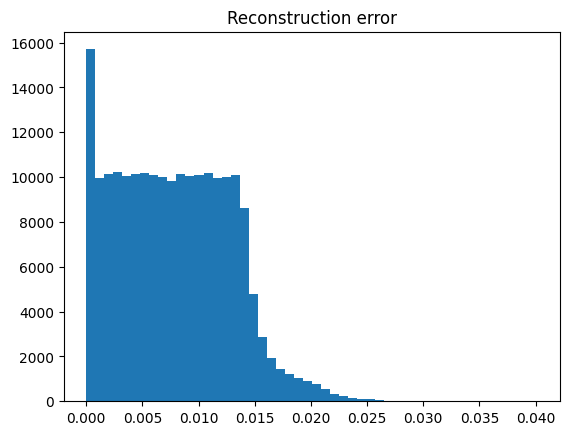

In [31]:
def get_reconstruction_error(runs=50):
    err = []
    for _ in range(runs):
        group_size = torch.randint(low=2, high=100, size=(1,)).item()
        t = rand(group_size, group_size)
        qdata, zero, scale = quant(t, group_size=group_size, packed=False)
        t_est = dequant(qdata, zero, scale, t.shape, group_size=group_size, packed=False)
        err.extend((t-t_est).abs().flatten().tolist())
    return err

plt.hist(get_reconstruction_error(), bins=50)
plt.title('Reconstruction error')
plt.show()

## 3. Quant zero and scales

fdsp-qdora sets `quant_zero` and `quant_scale` to `True`, which after quanting the data, applies quanting to the resulting `zero` and `scale`.

Let's so that as well.

In [32]:
# The current quant & dequant will be inner functions, used inside the new quant & dequant 
_quant = quant
_dequant = dequant

In [33]:
def quant(data, group_size, group_size_zero=None, group_size_scale=None, bits=3, packed=True):
    group_size_zero, group_size_scale = group_size_zero or group_size, group_size_scale or group_size
    qdata,  zero       , scale        = _quant(data,  group_size,       bits, packed)
    qzero,  zeros_zero , zeros_scale  = _quant(zero,  group_size_zero,  bits, packed)
    qscale, scales_zero, scales_scale = _quant(scale, group_size_scale, bits, packed)
    return qdata, qzero, qscale, zeros_zero, zeros_scale, scales_zero, scales_scale

In [34]:
# use a different example,
# - with shape (4,4) as example, so group_size divides rows (for data quanting) & cols (for zero/scale quanting)
# - different columsn (otherwise zero/scales are equal, and they themselves then have scale of 1/range = 1/0) 
some_data = torch.randint(low=0, high=20, size=(4,4))
some_data

tensor([[18, 19, 12, 10],
        [11, 18, 15, 14],
        [11, 10,  6, 11],
        [ 1,  4,  6, 17]])

In [35]:
quant(some_data, group_size=4, bits=3, packed=False)

(tensor([[7., 7., 5., 0.],
         [4., 7., 7., 4.],
         [4., 3., 0., 1.],
         [0., 0., 0., 7.]]),
 tensor([[7.],
         [6.],
         [4.],
         [0.]]),
 tensor([[7.],
         [6.],
         [1.],
         [0.]]),
 tensor([[7.30]]),
 tensor([[1.37]]),
 tensor([[-4.90]]),
 tensor([[0.20]]))

In [36]:
from hqq.core.quantize import HQQLinear

In [37]:
base_linear = nn.Linear(8,8,bias=False) # for hqq, group_size needs to be multiple of 8
base_linear.weight.data

tensor([[ 0.07,  0.16,  0.02,  0.18,  0.10, -0.34, -0.22,  0.17],
        [-0.11,  0.28, -0.09, -0.17, -0.26, -0.19,  0.32,  0.33],
        [-0.15,  0.21,  0.04, -0.12, -0.15,  0.12,  0.34, -0.01],
        [-0.13,  0.25,  0.05,  0.16,  0.10, -0.35,  0.12, -0.19],
        [-0.32, -0.18,  0.02, -0.29,  0.08,  0.06,  0.22, -0.09],
        [-0.29,  0.27,  0.17,  0.10, -0.35,  0.27, -0.06,  0.20],
        [-0.04, -0.02,  0.07, -0.27, -0.06, -0.15, -0.23,  0.04],
        [-0.10, -0.32,  0.32, -0.17, -0.20,  0.16, -0.07, -0.33]])

In [38]:
hqq_cfg = dict(
    weight_quant_params = dict(nbits=3, group_size=8, bitpack=False, optimize=False),
    scale_quant_params  = dict(nbits=3, group_size=8, bitpack=False, optimize=False),
    # hqq sets channel_wise=False for zeros, which makes the min/max calculation be over all the data, not per group.
    # that's okay, because the zeros will all be in range tbd --- todo: umer
    # we'll ignore that for now
    zero_quant_params   = dict(nbits=3, group_size=8, bitpack=False, optimize=False),
    offload_meta = False
)

In [39]:
hqq_linear = HQQLinear(base_linear, hqq_cfg, compute_dtype=fp32) # for simplicity, use fp32; default is fp16
hqq_linear

HQQLinear(in_features=8, out_features=8, bias=False)

In [40]:
hqq_linear.W_q.data

tensor([[7., 6., 2., 7., 7., 0., 0., 5.],
        [4., 7., 0., 2., 1., 2., 7., 7.],
        [3., 6., 2., 3., 3., 5., 7., 3.],
        [3., 7., 2., 7., 7., 0., 4., 1.],
        [0., 2., 2., 0., 7., 5., 6., 2.],
        [1., 7., 4., 6., 0., 7., 2., 6.],
        [5., 3., 3., 0., 4., 2., 0., 4.],
        [4., 0., 7., 2., 2., 6., 2., 0.]], device='cuda:0')

In [41]:
names = 'qdata qzero qscale zeros_zero zeros_scale scales_zero scales_scales'.split(' ')
items_hqq = L([
    hqq_linear.W_q.data,
    hqq_linear.meta['zero_q'],
    hqq_linear.meta['scale_q'],
    hqq_linear.meta['meta_zero']['zero'],
    hqq_linear.meta['meta_zero']['scale'],
    hqq_linear.meta['meta_scale']['zero'],
    hqq_linear.meta['meta_scale']['scale'],
]).map(Self.cpu())

In [42]:
items_ours = quant(base_linear.weight.data, group_size=8, bits=3, packed=False)

In [43]:
table = zip(names, items_hqq, items_ours)
print(tabulate(table, headers=['Name', 'HQQ Item', 'Our Item'], tablefmt='grid'))

+---------------+--------------------------------------------+--------------------------------------------+
| Name          | HQQ Item                                   | Our Item                                   |
+===============+============================================+============================================+
| qdata         | tensor([[7., 6., 2., 7., 7., 0., 0., 5.],  | tensor([[7., 6., 2., 7., 7., 0., 0., 5.],  |
|               |         [4., 7., 0., 2., 1., 2., 7., 7.],  |         [4., 7., 0., 2., 1., 2., 7., 7.],  |
|               |         [3., 6., 2., 3., 3., 5., 7., 3.],  |         [3., 6., 2., 3., 3., 5., 7., 3.],  |
|               |         [3., 7., 2., 7., 7., 0., 4., 1.],  |         [3., 7., 2., 7., 7., 0., 4., 1.],  |
|               |         [0., 2., 2., 0., 7., 5., 6., 2.],  |         [0., 2., 2., 0., 7., 5., 6., 2.],  |
|               |         [1., 7., 4., 6., 0., 7., 2., 6.],  |         [1., 7., 4., 6., 0., 7., 2., 6.],  |
|               |         [5

In [44]:
for ohqq,oours in zip(items_hqq, items_ours): assert_close(ohqq, oours)

In [45]:
def test_double_quant_against_hqq(runs=50):
    for _ in range(runs):
        group_size = torch.randint(low=2, high=100, size=(1,)).item()
        lin = nn.Linear(group_size, group_size, bias=False)

        cfg = deepcopy(hqq_cfg)
        for o in ['weight', 'scale', 'zero']: cfg[o+'_quant_params']['group_size'] = group_size
        
        hqq_lin = HQQLinear(lin, cfg, compute_dtype=fp32) # for simplicity, use fp32; default is fp16)
        
        names = 'qdata qzero qscale zeros_zero zeros_scale scales_zero scales_scales'.split(' ')
        items_hqq = L([
            hqq_lin.W_q.data,
            hqq_lin.meta['zero_q'],
            hqq_lin.meta['scale_q'],
            hqq_lin.meta['meta_zero']['zero'],
            hqq_lin.meta['meta_zero']['scale'],
            hqq_lin.meta['meta_scale']['zero'],
            hqq_lin.meta['meta_scale']['scale'],
        ]).map(Self.cpu())
        items_ours = quant(lin.weight.data, group_size=group_size, bits=3, packed=False)
        
        for o1,o2 in zip(items_hqq, items_ours): assert_close(o1,o2)
    print(f'Tested for {runs} runs - Looks good ✓')

test_double_quant_against_hqq()

Tested for 50 runs - Looks good ✓


Let's now adapt the dequant function:

In [46]:
def dequant(qdata, qzero, qscale, zeros_zero, zeros_scale, scales_zero, scales_scale, data_shape, zero_shape, scale_shape, group_size, group_size_zero, group_size_scale, packed):
    zero  = _dequant(qzero,  zeros_zero,  zeros_scale,  zero_shape,  group_size_zero,  packed)
    scale = _dequant(qscale, scales_zero, scales_scale, scale_shape, group_size_scale, packed)
    return _dequant(qdata, zero, scale, data_shape, group_size, packed)

In [47]:
gz = randint(1, lo=2, hi=100) # group_size
print(f'Group size: {gz}')
data = rand(gz, gz)
items = quant(data, gz, packed=False)

Group size: 39


In [48]:
W_est = dequant(
    *items,
    (gz,gz), (1,gz), (1,gz),
    gz, gz, gz,
    packed=False
)

assert_somehow_close(data, W_est)

In [49]:
def test_quant_dequant(runs=50):
    for _ in range(runs):
        gz = randint(1, lo=2, hi=100)
        t = rand(gz, gz)
        items = quant(t, gz, packed=False)        
        t_est = dequant(
            *items,
            (gz,gz), (1,gz), (1,gz), # shapes
            gz, gz, gz, # group sizes
            packed=False
        )
        assert_somehow_close(t, t_est)
    print(f'Tested for {runs} runs - Looks good ✓')

test_quant_dequant(50) # error is random, and can rarely be a bit larger, so if this fails, rerun in and verify this fails only rarely

Tested for 50 runs - Looks good ✓


## 4. Use hqq's optimization in quanting

Finally, let's use hqq's optimizer in our quanting method. We won't implement it ourselves, because for our goal (making qdora faaast), it doesn't matter.

In [50]:
def _quant(data, group_size, bits=3, packed=True, optimize=False):
    assert data.numel()%group_size==0, f'group_size {group_size} can\'t evenly split the data (numel = {data.numel()})'
    data = data.float().reshape(group_size,-1)
    
    min_, max_ = data.min(axis=0, keepdim=True).values, data.max(axis=0, keepdim=True).values

    scale = (2**bits-1) / (max_-min_) # note: hqq clamp to 2e4 to avoid half-precision problems, let's ignore that for now
    zero = -min_ * scale

    if optimize: data, scale, zero = Quantizer.optimize_weights(data, scale, zero, min_max=[0, 2**bits-1])
    else: data = (data * scale + zero).round()

    # packed quantized data
    if packed: data = pack(data)

    return data, zero, 1/scale # we invert scale, so we can do multiplication instead of division in dequanting

In [51]:
print(tabulate(zip(
    _quant(some_data, group_size=4, optimize=True, packed=False),
    _quant(some_data, group_size=4, optimize=False, packed=False)
), headers=['Optimized', 'Not optimized'], tablefmt='grid'))

+--------------------------------------------+--------------------------------------------+
| Optimized                                  | Not optimized                              |
+============================================+============================================+
| tensor([[7., 7., 5., 0.],                  | tensor([[7., 7., 5., 0.],                  |
|         [4., 7., 7., 4.],                  |         [4., 7., 7., 4.],                  |
|         [4., 3., 0., 1.],                  |         [4., 3., 0., 1.],                  |
|         [-0., 0., 0., 7.]])                |         [0., 0., 0., 7.]])                 |
+--------------------------------------------+--------------------------------------------+
| tensor([[ -0.46,  -1.83,  -4.63, -10.00]]) | tensor([[ -0.41,  -1.87,  -4.67, -10.00]]) |
+--------------------------------------------+--------------------------------------------+
| tensor([[2.43, 2.14, 1.29, 1.00]])         | tensor([[2.43, 2.14, 1.29, 1.00]]

In [52]:
hqq_results = Quantizer.quantize(some_data, group_size=4, nbits=3, optimize=True, bitpack=False)
items_hqq = [hqq_results[0], hqq_results[1]['zero'], hqq_results[1]['scale']]
items_ours = _quant(some_data, group_size=4, optimize=True, packed=False)

print(tabulate(zip(items_hqq, items_ours), headers=['HQQ', 'Ours'], tablefmt='grid'))

+-----------------------------------------------------------------+--------------------------------------------+
| HQQ                                                             | Ours                                       |
+=================================================================+============================================+
| tensor([[7, 7, 5, 0],                                           | tensor([[7., 7., 5., 0.],                  |
|         [4, 7, 7, 4],                                           |         [4., 7., 7., 4.],                  |
|         [4, 3, 0, 1],                                           |         [4., 3., 0., 1.],                  |
|         [0, 0, 0, 7]])                                          |         [-0., 0., 0., 7.]])                |
+-----------------------------------------------------------------+--------------------------------------------+
| tensor([[ -0.46,  -1.83,  -4.63, -10.00]], dtype=torch.float16) | tensor([[ -0.46,  -1.83,  -4

## 6. Put it all together!

Put everything together, and added `compute_dtype` param, so `self.dequant()@x` in `forward` works.

In [53]:
class QuantedDoraModule(nn.Module):
    def __init__(self, linear, bits, group_size, rank, alpha, compute_dtype=fp16, packed=True, optimized=True, group_size_zero=None, group_size_scale=None):
        super().__init__()
        # for quanting
        store_attr('bits,group_size,packed,optimized,compute_dtype',self)
        self.group_size_zero, self.group_size_scale = group_size_zero or 128, group_size_scale or 128 # hqq uses group size of 128 for zero & scale
        self.quant(linear.weight.data)
        # for dora
        self.a = nn.Linear(linear.in_features, rank, bias=False, dtype=fp16)
        self.b = nn.Linear(rank, linear.out_features, bias=False, dtype=fp16)
        self.alpha = alpha
        self.m = nn.Parameter(linear.weight.norm(p=2, dim=1))
        # init a & b to 0 -- a should be inited differently, but for sake of simplicity, set it to 0 as well
        self.a.weight.data.zero_()
        self.b.weight.data.zero_()

    @staticmethod
    def pack(vals):
        assert len(vals.shape)==2, 'Pass a 2d tensor'
        for v in vals.flatten(): assert 0<=v.item()<=7 and v.item()//1==v.item(), f'Value {v} can\'t be represented by 3 bits or is not an integer'    
        rows, cols = vals.shape
        n_packs = ceil(rows/10)
        padded_vals = torch.zeros(n_packs*10, cols, dtype=int32)
        padded_vals[:rows, :cols] = vals
        packed = torch.zeros(n_packs, cols, dtype=int32)
        for k in range(10): packed = (packed << 3) | padded_vals[k*n_packs:(k+1)*n_packs,:] # shift right 3 bits, then set last 3 bits to padded_vals[...,...]
        return packed

    @staticmethod
    def unpack(packed, rows):
        def bin_to_dec(b3,b2,b1): return 4*b3 + 2*b2 + b1
        assert len(packed.shape)==2 and packed.dtype==int32, 'Pass a 2d tensor of int32s'
        n_packs, cols = packed.shape
        padded_vals = torch.zeros(n_packs*10, cols, dtype=int32)
        for k_up, k_down in zip(range(10), reversed(range(10))): # top-most 3bits vals (k_up=0) are most right-shifted (k_down=9)
            padded_vals[k_down*n_packs:(k_down+1)*n_packs,:] = ((packed >> (3*k_up)) & 0b111) # righ-shift 3*k_up times, so last 3 bits are those we want; then only select those via 0b111            
        return padded_vals[:rows,:]
    
    @staticmethod
    def _quant(data, group_size, bits=3, packed=True, optimize=True):
        assert data.numel()%group_size==0, f'group_size {group_size} can\'t evenly split the data (numel = {data.numel()})'
        data = data.float().reshape(group_size,-1)
        
        min_, max_ = data.min(axis=0, keepdim=True).values, data.max(axis=0, keepdim=True).values
    
        scale = (2**bits-1) / (max_-min_) # note: hqq clamp to 2e4 to avoid half-precision problems, let's ignore that for now
        zero = -min_ * scale
    
        if optimize: data, scale, zero = Quantizer.optimize_weights(data, scale, zero, min_max=[0, 2**bits-1])
        else: data = (data * scale + zero).round()

        if packed: data = QuantedDoraModule.pack(data)
        return data, zero, 1/scale # invert scale, so in dequanting we multiply instead of divide 

    @staticmethod
    def _dequant(data, zero, scale, shape, group_size, packed=True):
        if packed: data = QuantedDoraModule.unpack(data, rows=group_size)
        data = (data-zero)*scale
        return data.reshape(shape)

    def quant(self, data):
        qdata,  zero       , scale        = self._quant(data,  self.group_size,       self.bits, self.packed, self.optimized)
        qzero,  zeros_zero , zeros_scale  = self._quant(zero,  self.group_size_zero,  self.bits, self.packed, False)
        qscale, scales_zero, scales_scale = self._quant(scale, self.group_size_scale, self.bits, self.packed, False)
        store_attr('qdata, qzero, qscale, zeros_zero, zeros_scale, scales_zero, scales_scale', self)
        self.data_shape,self.zero_shape,self.scale_shape = data.shape, zero.shape, scale.shape

    def dequant(self):
        zero  = self._dequant(self.qzero,  self.zeros_zero,  self.zeros_scale,  self.zero_shape,  self.group_size_zero,  self.packed)
        scale = self._dequant(self.qscale, self.scales_zero, self.scales_scale, self.scale_shape, self.group_size_scale, self.packed)
        return  self._dequant(self.qdata,  zero,             scale,             self.data_shape,  self.group_size,       self.packed).to(self.compute_dtype)
    
    def forward(self, x):
        x = self.dequant()@x + self.b(self.a(x))
        col_norms =  (self.dequant() + self.b.weight @ self.a.weight).norm(p=2, dim=1).detach()
        x /= col_norms
        x *= self.m * self.alpha
        return x

In [54]:
lin = nn.Linear(8,8, bias=False, dtype=fp16)
lin.weight.data

tensor([[-0.18,  0.16,  0.32,  0.20,  0.01, -0.23, -0.26, -0.13],
        [ 0.18, -0.15,  0.21,  0.12,  0.22,  0.15, -0.02, -0.28],
        [ 0.17,  0.18,  0.13, -0.17, -0.12,  0.21, -0.06,  0.17],
        [-0.22, -0.21, -0.28,  0.27,  0.13,  0.15,  0.30, -0.27],
        [ 0.08,  0.18,  0.01, -0.01,  0.06, -0.12, -0.26,  0.02],
        [-0.01,  0.13, -0.29,  0.09, -0.08, -0.19,  0.27, -0.15],
        [-0.07, -0.09,  0.27, -0.08, -0.18, -0.01,  0.20,  0.06],
        [ 0.12,  0.29, -0.31,  0.13, -0.03,  0.03,  0.13, -0.25]], dtype=torch.float16)

In [55]:
qdora_lin = QuantedDoraModule(lin, bits=3, group_size=8, rank=2, alpha=1, packed=True, optimized=True, group_size_zero=8, group_size_scale=8, compute_dtype=fp16)

In [56]:
qdora_lin.dequant()

tensor([[    -0.17,      0.13,      0.33,      0.20,     -0.01,     -0.23,     -0.27,     -0.15],
        [     0.17,     -0.15,      0.24,      0.14,      0.22,      0.14,     -0.03,     -0.28],
        [     0.17,      0.20,      0.15,     -0.17,     -0.12,      0.20,     -0.11,      0.19],
        [    -0.23,     -0.23,     -0.30,      0.26,      0.11,      0.14,      0.29,     -0.28],
        [     0.06,      0.20,      0.06,      0.02,      0.05,     -0.11,     -0.27,      0.05],
        [     0.00,      0.13,     -0.30,      0.08,     -0.07,     -0.17,      0.29,     -0.15],
        [    -0.06,     -0.08,      0.24,     -0.11,     -0.18,      0.01,      0.21,      0.05],
        [     0.11,      0.27,     -0.30,      0.14,     -0.01,      0.01,      0.13,     -0.28]], dtype=torch.float16)

In [57]:
max_abs_diff(lin.weight.data, qdora_lin.dequant())

tensor(0.05, dtype=torch.float16)

In [69]:
x = torch.randn(8, dtype=fp16)
y = lin(x)
y_qdora = qdora_lin(x)
print(f'{y}\n{y_qdora}')

tensor([ 0.33, -0.27,  0.04, -0.31,  0.14, -0.01,  0.10, -0.14], dtype=torch.float16, grad_fn=<SqueezeBackward4>)
tensor([ 0.31, -0.24,  0.06, -0.32,  0.17, -0.03,  0.07, -0.15], dtype=torch.float16, grad_fn=<MulBackward0>)


In [70]:
assert_somehow_close(y, y_qdora)